In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Analyse de personnalité client - Modélisation

Ce notebook réalise l'analyse non supervisée du jeu de données issu de la **Customer Personality Analysis** disponible sur Kaggle.
Nous allons:
1. Charger et explorer les données
2. Nettoyer et prétraiter le jeu de données
3. Réduire la dimension avec une sélection de variables et une analyse factorielle
4. Appliquer trois méthodes de clustering (k-means, CAH, DBSCAN)
5. Comparer les résultats et profiler les groupes obtenus
6. Conclure

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/marketing_campaign.csv', sep='	')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


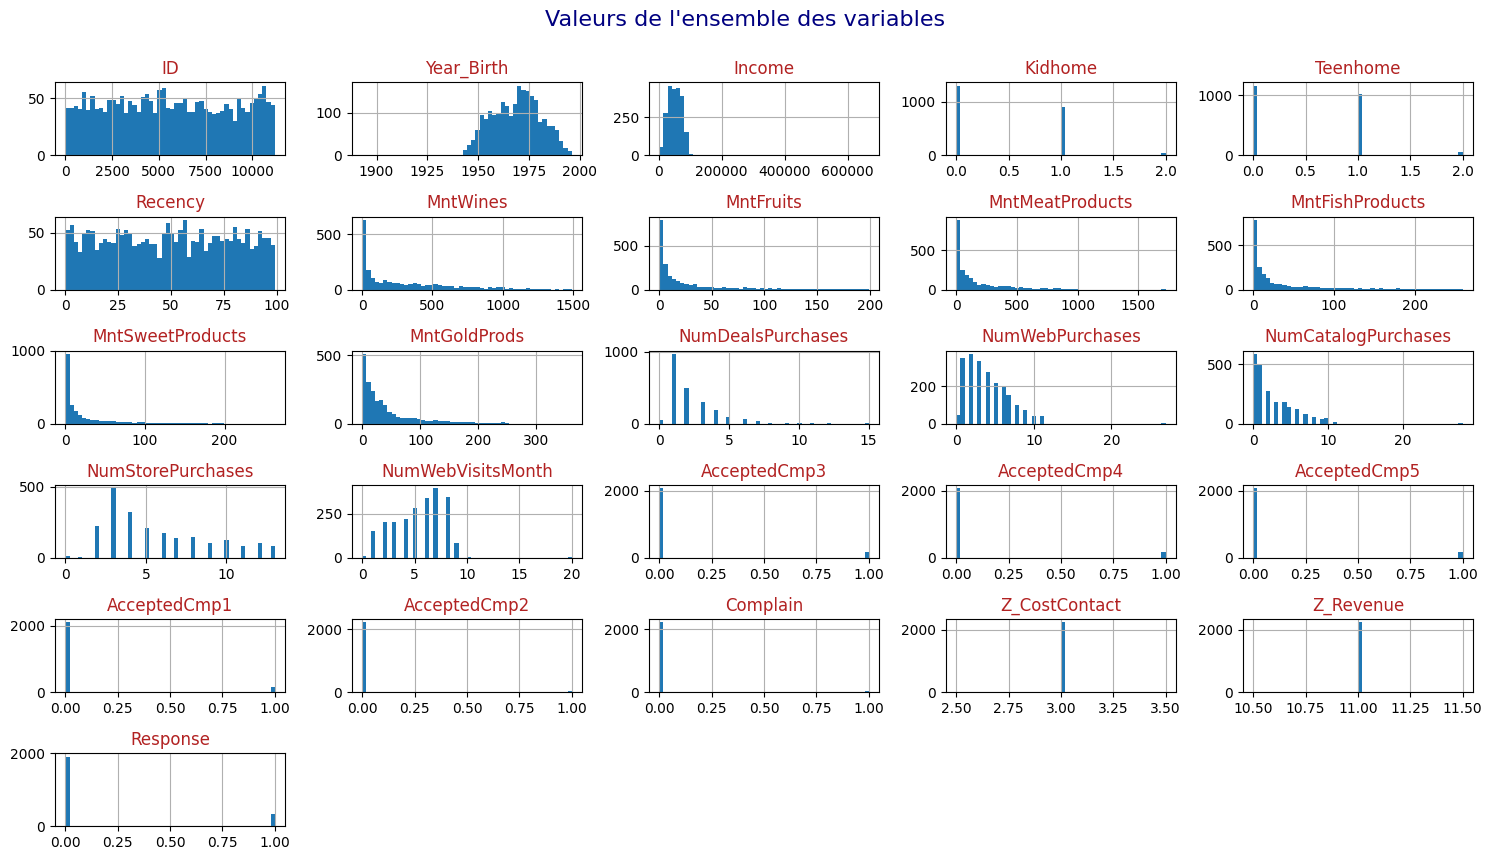

In [3]:
axes = df.hist(bins=50, figsize=(15,9))
plt.suptitle("Valeurs de l'ensemble des variables", fontsize=16, color="navy")
for ax in axes.ravel():
    ax.set_title(ax.get_title(), color='firebrick')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

## Cleaning & Outliers

String to categorical

In [4]:
education_map = {
    '2n Cycle': 1,
    'Basic': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
marital_map = {
    'Single': 1,
    'Divorced': 1,
    'Widow': 1,
    'Together': 2,
    'Married': 2,
    'Alone': 1,
    'Absurd': 1,
    'YOLO': 1
}
df['Education'] = df['Education'].map(education_map)
df['Marital_Status'] = df['Marital_Status'].map(marital_map)
df.shape

(2240, 29)

String(date) to int

In [5]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_For_Days'] = (reference_date - df['Dt_Customer']).dt.days
df.drop(columns='Dt_Customer', inplace=True)
df.shape

(2240, 29)

In [6]:
df = df[
    (df['Year_Birth'] > 1930) &
    (df['Income'] < 140000) &
    (df['MntMeatProducts'] < 1250) &
    (df['MntGoldProds'] < 300) &
    (df['MntSweetProducts'] < 300) &
    (df['NumWebPurchases'] < 15) &
    (df['NumCatalogPurchases'] < 15) &
    (df['NumWebVisitsMonth'] < 15)
]
df = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])
df.shape

(2195, 26)

In [7]:
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df.select_dtypes(include=[np.number]))
df['Outlier_IForest'] = outlier_pred
print(df['Outlier_IForest'].value_counts())
df = df[df['Outlier_IForest'] == 1].drop(columns='Outlier_IForest')
df.shape

Outlier_IForest
 1    2085
-1     110
Name: count, dtype: int64


(2085, 26)

- Features division

In [8]:
extract_x_continuous = df[['Year_Birth', 'Income', 'Recency', 'MntWines',
'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
'NumCatalogPurchases', 'NumStorePurchases',
'NumWebVisitsMonth', 'Customer_For_Days', 'MntFruits',
'MntMeatProducts',
'MntFishProducts',
'MntSweetProducts']]
extract_x_continuous.shape

(2085, 15)

? Kidhome & Teenhome sont des variables catégoriels ou Continues ?

In [9]:
extract_x_cat = df[['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 
'AcceptedCmp2', 'Complain', 'Response']]
extract_x_cat.shape

(2085, 11)

## Feature engenering

### Continuous features

Faire une corrélation de Pearson puis faire un CAH pour faire du feature engenering

In [10]:
df_num = pd.DataFrame(extract_x_continuous)
df_num['Age'] = 2015 - df_num['Year_Birth']
df_num.drop(columns='Year_Birth', inplace=True)

# df_num['Spending']=df_num['MntWines']+df_num['MntFruits']+df_num['MntMeatProducts']+df_num['MntFishProducts']+df_num['MntSweetProducts']+df_num['MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 
                'NumStorePurchases', 'NumDealsPurchases']
df_num['Total_Purchases'] = df_num[purchase_cols].sum(axis=1)

df_num['MntFoodTotal'] = df_num[['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
df_num.drop(columns=['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts'], inplace=True)

df_num.shape

(2085, 13)

In [11]:
print('Before F.E : ', extract_x_continuous.shape[1])
print('After F.E : ', df_num.shape[1])

Before F.E :  15
After F.E :  13


### Categorical features

In [12]:
print('Before F.E : ', extract_x_cat.shape[1])
df_cat = pd.DataFrame(extract_x_cat)
df_cat['Children']=df_cat['Kidhome']+df_cat['Teenhome']

print('After F.E : ', df_cat.shape[1])

Before F.E :  11
After F.E :  12


## PCA

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_num.columns, index=df_num.index)

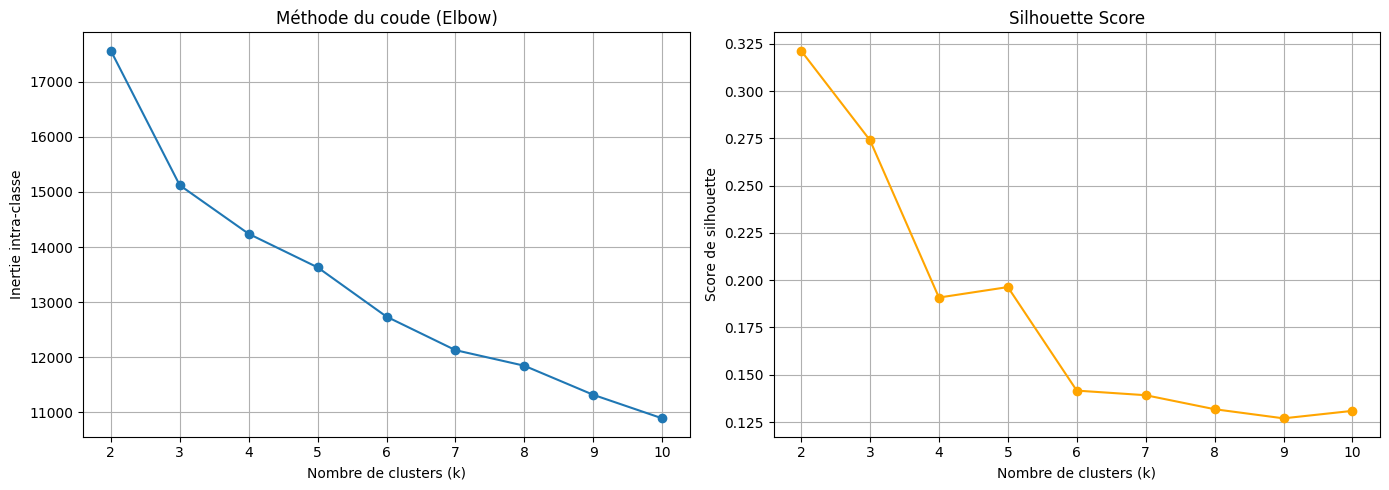

In [14]:
inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled_df)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled_df, labels))

# Affichage combiné
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title("Méthode du coude (Elbow)")
ax[0].set_xlabel("Nombre de clusters (k)")
ax[0].set_ylabel("Inertie intra-classe")
ax[0].grid(True)

# Silhouette
ax[1].plot(k_range, silhouettes, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Nombre de clusters (k)")
ax[1].set_ylabel("Score de silhouette")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled_df)

In [16]:
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(X_scaled_df)
print('Nombre de composantes conservées :', pca.n_components_)

Nombre de composantes conservées : 9


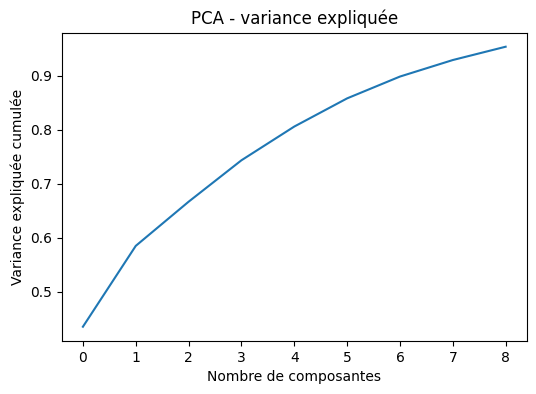

In [17]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - variance expliquée')
plt.show()

### 2D

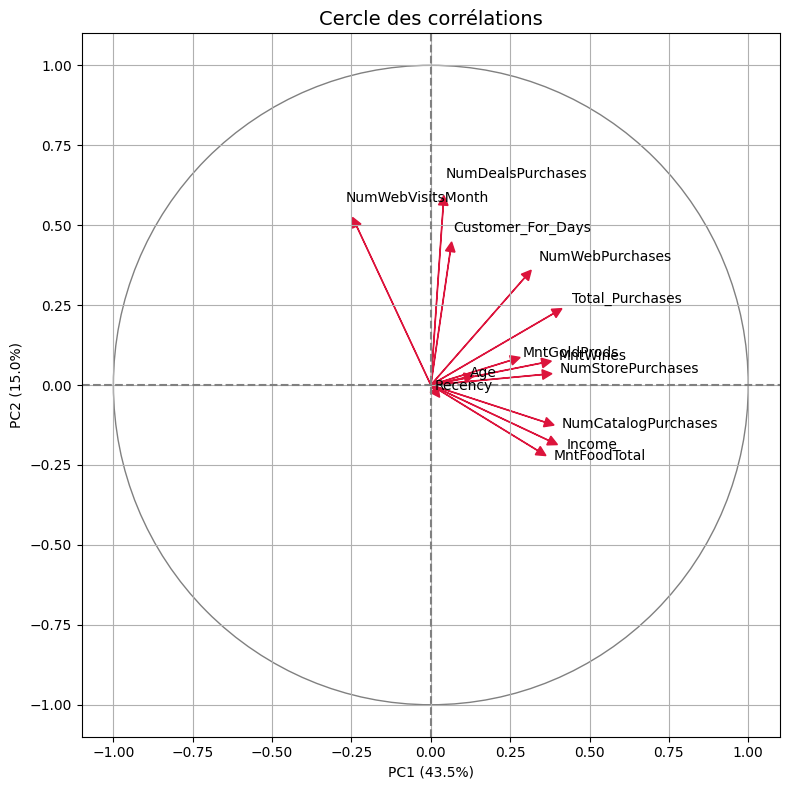

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax.add_artist(circle)

pc1 = pca.components_[0]
pc2 = pca.components_[1]

for i in range(len(X_scaled_df.columns)):
    x, y = pc1[i], pc2[i]
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='crimson', ec='crimson')
    ax.text(x * 1.15, y * 1.15, X_scaled_df.columns[i], fontsize=10)

ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Cercle des corrélations", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


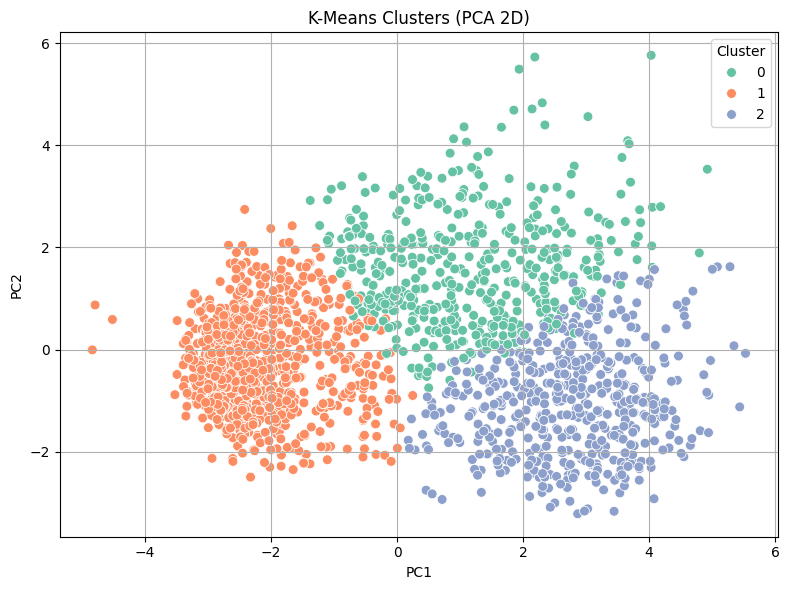

In [19]:
X_visu = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_visu[:,0], y=X_visu[:,1], hue=labels_kmeans, palette='Set2', s=50)
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

Silhouette Score (k=3) : 0.274
Calinski-Harabasz Score (k=3) : 825.102
Davies-Bouldin Score (k=3) : 1.683


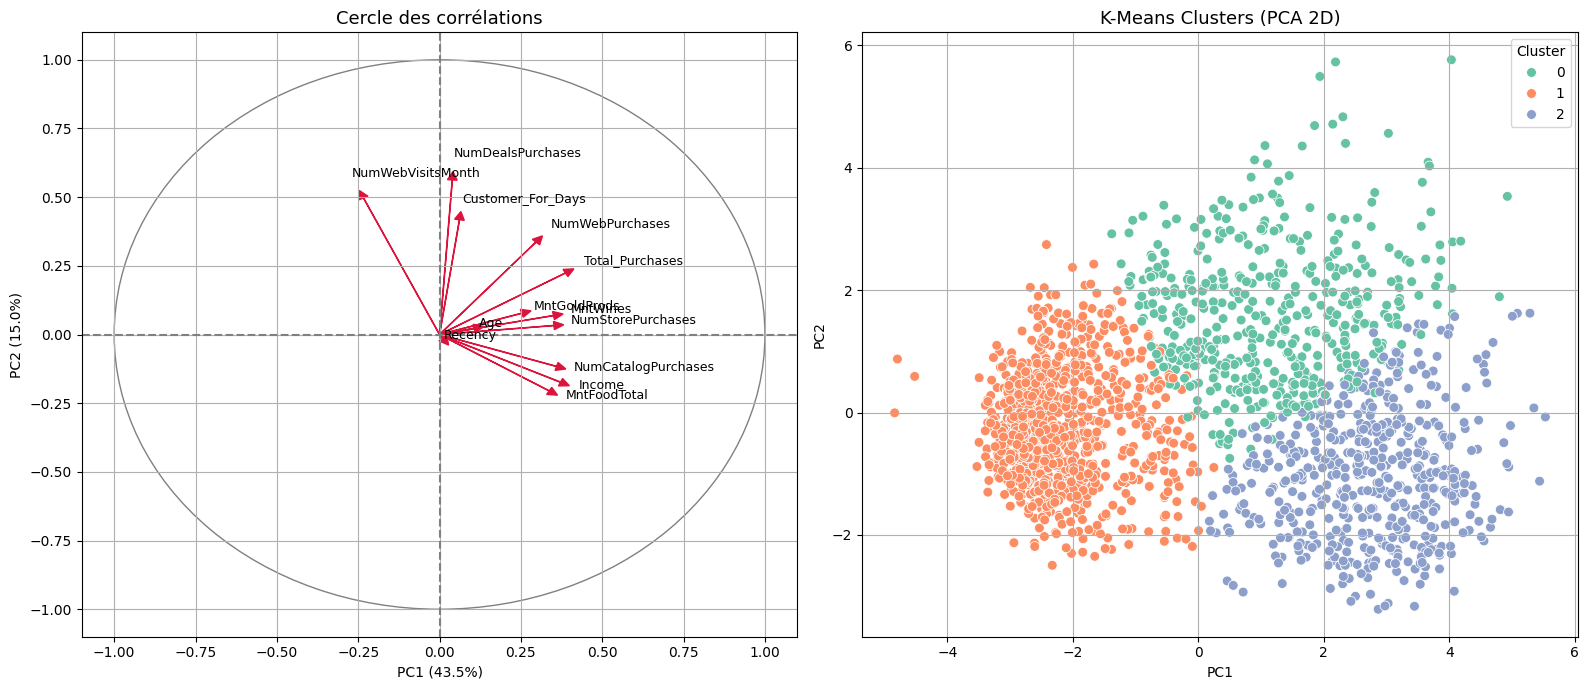

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
pc1 = pca.components_[0]
pc2 = pca.components_[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax1.add_artist(circle)

for i in range(len(X_scaled_df.columns)):
    x, y = pc1[i], pc2[i]
    ax1.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='crimson', ec='crimson')
    ax1.text(x * 1.15, y * 1.15, X_scaled_df.columns[i], fontsize=9)

ax1.axhline(0, color='grey', linestyle='--')
ax1.axvline(0, color='grey', linestyle='--')
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax1.set_title("Cercle des corrélations", fontsize=13)
ax1.grid(True)

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_kmeans,
    palette='Set2',
    s=50,
    ax=ax2
)
ax2.set_title("K-Means Clusters (PCA 2D)", fontsize=13)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend(title="Cluster")
ax2.grid(True)

silhouette_scorer = silhouette_score(X_scaled_df, labels_kmeans)
calinski_harabasz_scorer = calinski_harabasz_score(X_scaled_df, labels_kmeans)
davies_bouldin_scorer = davies_bouldin_score(X_scaled_df, labels_kmeans)
print(f"Silhouette Score (k=3) : {silhouette_scorer:.3f}")
print(f"Calinski-Harabasz Score (k=3) : {calinski_harabasz_scorer:.3f}")
print(f"Davies-Bouldin Score (k=3) : {davies_bouldin_scorer:.3f}")

plt.tight_layout()
plt.show()


In [21]:
df_union = pd.concat([df_num, df_cat], axis=1)
df_union['Cluster'] = labels_kmeans  # ou labels_cah
global_means = df_union.drop(columns='Cluster').mean()
cluster_means = df_union.groupby('Cluster').mean()

# Écart relatif en %
comparison_matrix = ((cluster_means - global_means) / global_means * 100).round(1)

# Créer un masque de la même taille pour colorer uniquement les 5 valeurs max absolues par ligne
def color_top_features(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    
    for idx in df.index:
        # Obtenir les 5 colonnes avec l'écart relatif absolu le plus grand
        top5 = df.loc[idx].abs().sort_values(ascending=False).head(5).index
        
        for col in top5:
            if idx == 0:
                styles.loc[idx, col] = 'background-color: green' # Cluster 0 : Promo shopper 
            elif idx == 1:
                styles.loc[idx, col] = 'background-color: brown'  # Cluster 1 : Low value passive
            elif idx == 2:
                styles.loc[idx, col] = 'background-color: blue'   # Cluster 2 : High value loyal

    return styles

# Appliquer le style
styled = comparison_matrix.style.apply(color_top_features, axis=None)
styled

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.


### 🔵 Cluster 0 – "Acheteurs réguliers promo-sensibles"

💡 Caractéristiques dominantes :



NumDealsPurchases, AcceptedCmp4, AcceptedCmp2 très élevés


Bons scores en NumWebPurchases, Teenhome, Response


Revenu légèrement supérieur à la moyenne


- ✅ Interprétation :


- Ce sont des clients actifs, réactifs aux promotions, plutôt jeunes parents (ados à la maison), engagés dans la relation commerciale. Potentiellement sensibles au marketing et fidèles.



### 🟠 Cluster 1 – "Clients passifs à bas revenu"

💡 Caractéristiques dominantes :



Très faibles scores en MntWines, MntFoodTotal, AcceptedCmp5, AcceptedCmp1, AcceptedCmp4


Revenu faible, peu d’achats en général


- ✅ Interprétation :


- Ce cluster regroupe les clients les moins rentables, peu réactifs aux campagnes marketing, avec peu de consommation. Peut-être des profils retraités, désengagés, ou peu attachés à la marque.



### 🟣 Cluster 2 – "Premium engagés et gros consommateurs"

💡 Caractéristiques dominantes :



AcceptedCmp1 (+247 %), AcceptedCmp2, MntWines, MntFoodTotal, NumCatalogPurchases très élevés


Revenu élevé, très consommateurs


- ✅ Interprétation :


- Ce sont les meilleurs clients, engagés dans les campagnes, à haut pouvoir d’achat, très rentables. À chouchouter ! Ce sont tes VIP.

Nous obtenons un score de silhouette assez bas car les clusters sont imbriqués les uns dans les autres. Cependant, ils semblent cohérents, essayons de les afficher en 3D.

Silhouette Score (k=3) : 0.255
Calinski-Harabasz Score (k=3) : 137.167
Davies-Bouldin Score (k=3) : 1.379


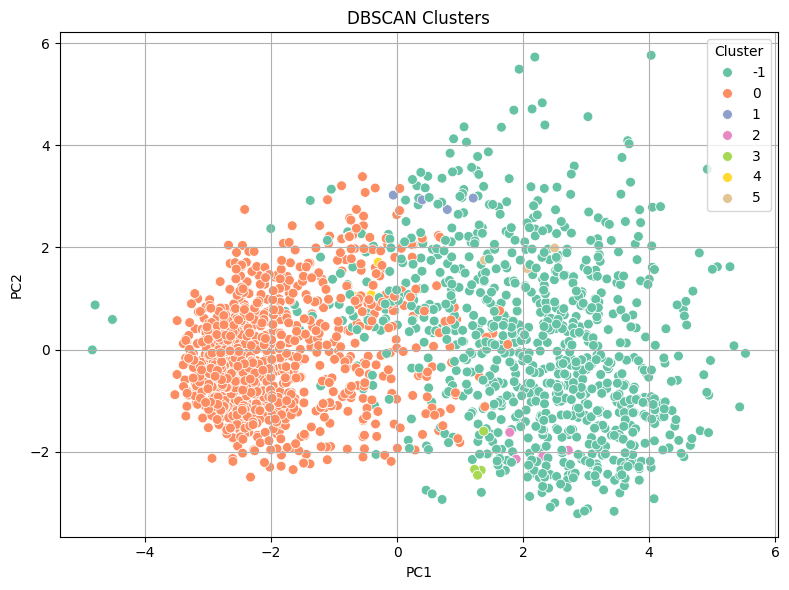

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled_df)

mask_dbscan = labels_dbscan != -1
if len(set(labels_dbscan[mask_dbscan])) > 1:
    score_sil = silhouette_score(X_scaled_df[mask_dbscan], labels_dbscan[mask_dbscan])
    score_calinski = calinski_harabasz_score(X_scaled_df[mask_dbscan], labels_dbscan[mask_dbscan])
    score_davies = davies_bouldin_score(X_scaled_df[mask_dbscan], labels_dbscan[mask_dbscan])
else:
    score_db = float('nan')

silhouette_scorer = silhouette_score(X_scaled_df[mask_dbscan], labels_kmeans[mask_dbscan])
calinski_harabasz_scorer = calinski_harabasz_score(X_scaled_df[mask_dbscan], labels_kmeans[mask_dbscan])
davies_bouldin_scorer = davies_bouldin_score(X_scaled_df[mask_dbscan], labels_kmeans[mask_dbscan])
print(f"Silhouette Score (k=3) : {silhouette_scorer:.3f}")
print(f"Calinski-Harabasz Score (k=3) : {calinski_harabasz_scorer:.3f}")
print(f"Davies-Bouldin Score (k=3) : {davies_bouldin_scorer:.3f}")

# Visualisation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_dbscan, palette='Set2', s=50)
plt.title(f"DBSCAN Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

Silhouette Score (CAH) : 0.198
Calinski-Harabasz Score (CAH) : 685.645
Davies-Bouldin Score (CAH) : 1.828


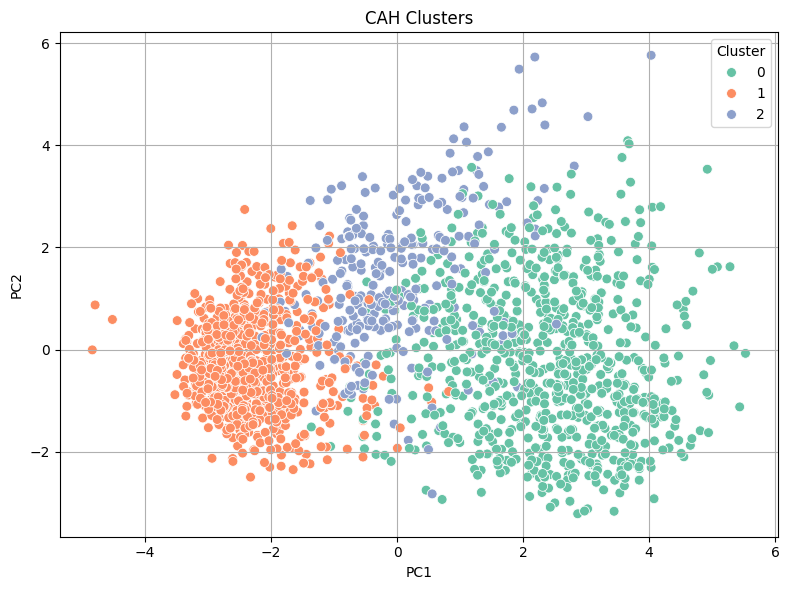

In [ ]:
cah = AgglomerativeClustering(n_clusters=3)
labels_cah = cah.fit_predict(X_scaled_df)

# Silhouette
score_sil = silhouette_score(X_scaled_df, labels_cah)
score_calinski = calinski_harabasz_score(X_scaled_df, labels_cah)
score_davies = davies_bouldin_score(X_scaled_df, labels_cah)
print(f"Silhouette Score (CAH) : {score_sil:.3f}")
print(f"Calinski-Harabasz Score (CAH) : {score_calinski:.3f}")
print(f"Davies-Bouldin Score (CAH) : {score_davies:.3f}")
# Visualisation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_cah, palette='Set2', s=50)
plt.title(f"CAH Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


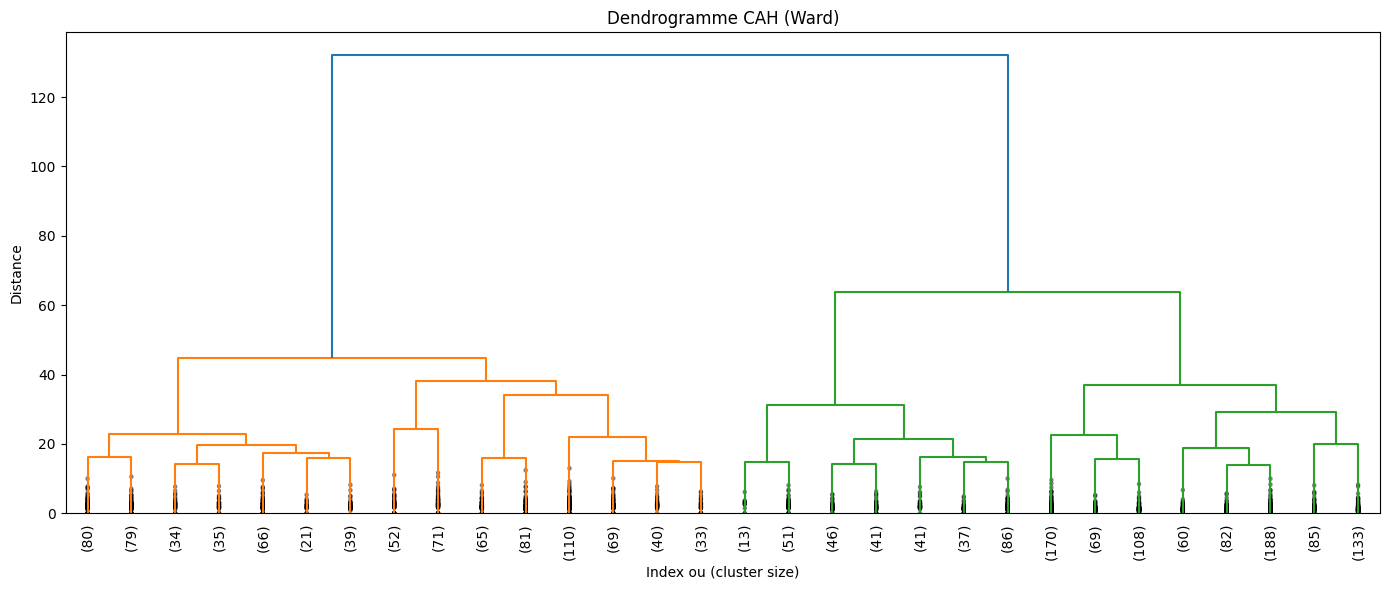

In [ ]:
Z = linkage(X_scaled_df, method='ward')
plt.figure(figsize=(14, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title("Dendrogramme CAH (Ward)")
plt.xlabel("Index ou (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### 3D

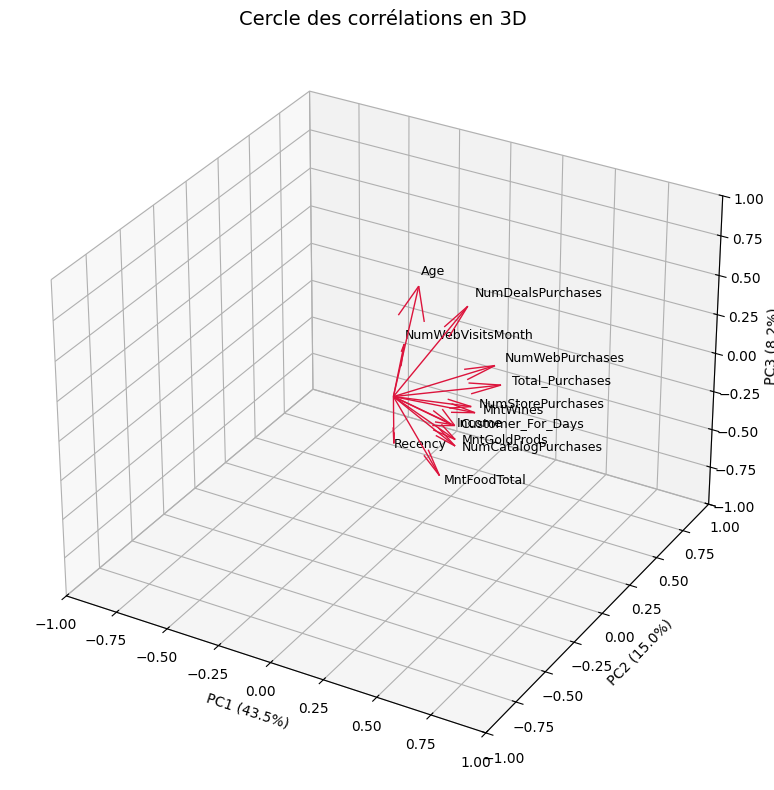

In [ ]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled_df)
components = pca_3d.components_

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Flèches (vecteurs)
for i in range(len(X_scaled_df.columns)):
    x, y, z = components[0, i], components[1, i], components[2, i]
    ax.quiver(0, 0, 0, x, y, z, color='crimson', linewidth=1)
    ax.text(x * 1.1, y * 1.1, z * 1.1, X_scaled_df.columns[i], fontsize=9)

# Axes et labels
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel(f"PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)")
ax.set_title("Cercle des corrélations en 3D", fontsize=14)

plt.tight_layout()
plt.show()


/tmp/ipykernel_8604/494999403.py:27: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



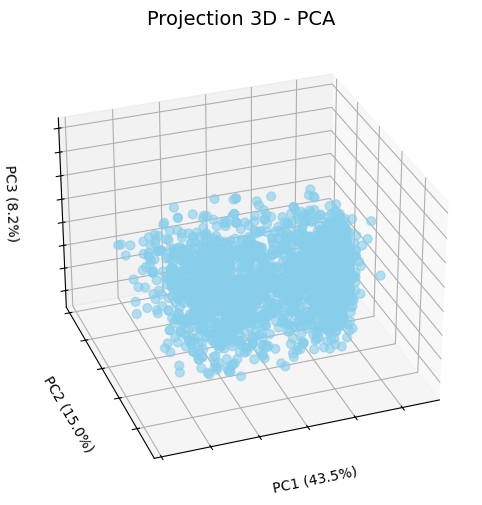

In [ ]:
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled_df)

# Visualisation 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)

# Scatter plot (aucun label ici, tu peux utiliser un clustering ou autre pour colorier)
scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c='skyblue',  # ou remplace par `labels_kmeans` si disponible
    s=40,
    alpha=0.6
)

# Configuration des axes
ax.set_title("Projection 3D - PCA", fontsize=14)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled_df)

pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Cercle des corrélations 3D", "K-Means Clusters (PCA 3D)"),
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]]
)

# --- Graphique 1: Cercle des corrélations 3D ---

# Création de la sphère unitaire (équivalent du cercle en 2D)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

# Ajout de la sphère unitaire
fig.add_trace(
    go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        opacity=0.1,
        colorscale='Greys',
        showscale=False,
        name="Sphère unitaire"
    ),
    row=1, col=1
)

# Ajout des vecteurs (flèches) pour chaque variable
for i in range(len(X_scaled_df.columns)):
    x, y, z = pc1[i], pc2[i], pc3[i]
    
    # Vecteur principal
    fig.add_trace(
        go.Scatter3d(
            x=[0, x], y=[0, y], z=[0, z],
            mode='lines',
            line=dict(color='crimson', width=4),
            name=X_scaled_df.columns[i],
            showlegend=False
        ),
        row=1, col=1
    )
    
    # Pointe de la flèche (approximation)
    fig.add_trace(
        go.Scatter3d(
            x=[x], y=[y], z=[z],
            mode='markers',
            marker=dict(color='crimson', size=5, symbol='diamond'),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # Étiquettes des variables
    fig.add_trace(
        go.Scatter3d(
            x=[x * 1.15], y=[y * 1.15], z=[z * 1.15],
            mode='text',
            text=[X_scaled_df.columns[i]],
            textposition='middle center',
            showlegend=False
        ),
        row=1, col=1
    )

# Ajout des axes de référence
axis_length = 1.2
# Axe X
fig.add_trace(
    go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='grey', width=2, dash='dash'),
        showlegend=False
    ),
    row=1, col=1
)
# Axe Y
fig.add_trace(
    go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='grey', width=2, dash='dash'),
        showlegend=False
    ),
    row=1, col=1
)
# Axe Z
fig.add_trace(
    go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='grey', width=2, dash='dash'),
        showlegend=False
    ),
    row=1, col=1
)

# --- Graphique 2: Clusters K-Means 3D ---

# Création d'une palette de couleurs pour les clusters
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
unique_labels = np.unique(labels_kmeans)

for i, label in enumerate(unique_labels):
    mask = labels_kmeans == label
    fig.add_trace(
        go.Scatter3d(
            x=X_pca[mask, 0],
            y=X_pca[mask, 1],
            z=X_pca[mask, 2],
            mode='markers',
            marker=dict(
                color=colors[i % len(colors)],
                size=5,
                opacity=0.8
            ),
            name=f'Cluster {label}'
        ),
        row=1, col=2
    )

# Configuration des axes pour le graphique 1
fig.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        yaxis_title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
        zaxis_title=f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
        xaxis=dict(range=[-1.2, 1.2]),
        yaxis=dict(range=[-1.2, 1.2]),
        zaxis=dict(range=[-1.2, 1.2]),
        aspectmode='cube'
    ),
    scene2=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
        aspectmode='cube'
    ),
    height=600,
    width=1400,
    title_text="Analyse en Composantes Principales 3D"
)

# Affichage du score de silhouette
score = silhouette_score(X_scaled_df, labels_kmeans)
print(f"Silhouette Score (k=3) : {score:.3f}")

# Affichage de la variance expliquée
total_variance = sum(pca.explained_variance_ratio_[:3])
print(f"Variance expliquée totale (3 composantes) : {total_variance*100:.1f}%")

fig.show()

Silhouette Score (k=3) : 0.274
Variance expliquée totale (3 composantes) : 66.6%
